In [700]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import matplotlib.colors as colors


In [701]:
def box(x, c1, c2):
    return np.where((x >= c1) & (x <= c2), 1, 0)

def double_slit_mask(x, c1, c2, ca, cb):
    return box(x, c1, c2) + box(x, ca, cb)

def sin_sample(x, freq, phase):
    return np.sin(2 * np.pi * freq * x + phase)

def generate_data_single_gate(rate, f_0, phase_0, box_width, padding):
    # box width, padding in seconds
    t = np.arange(0, padding*2 + box_width, 1/rate)
    pad_idx = np.argmin(np.abs(t-padding))
    c1 = t[pad_idx]
    c2 = t[-pad_idx]
    mask = box(t, c1, c2)
    t = t - (padding + box_width/2)
    signal = sin_sample(t, f_0, phase_0)
    data = signal * mask
    return t, data

def generate_data_double_gate(rate, f_0, phase_0, box_width, box_sep, pad):
    # box width, pad, etc in time units
    total_time = 2*pad+2*box_width+box_sep
    t = np.arange(0, total_time, 1/rate)
    c1 = t[np.argmin(np.abs(t-pad))]
    c2 = t[np.argmin(np.abs(t-(pad+box_width)))]
    ca = t[np.argmin(np.abs(t-(pad+box_width+box_sep)))]
    cb = t[np.argmin(np.abs(t-(pad+box_width+box_sep+box_width)))]
    mask = double_slit_mask(t, c1, c2, ca, cb)
    t = t - (pad + box_width/2)
    signal = sin_sample(t, f_0, phase_0)
    data = signal * mask
    return t, data

def add_noise(data, noise_level):
    noise = np.random.normal(0, noise_level, size=data.shape)
    return data + noise

def get_real_data(data_t, data_gate, want_noise=False):
    t_list = []
    data_list = []
    for i, t in enumerate(data_t):
        if data_gate[i] != 0:
            t_list.append(t)
            data_list.append(data_gate[i])

    data1 = add_noise(np.array(data_list), noise_level=0.1)
    data2 = add_noise(np.array(data_list), noise_level=0.2)
    data3 = add_noise(np.array(data_list), noise_level=0.1)
    data_avg = np.mean([data1, data2, data3], axis=0)
    data_std = np.std([data1, data2, data3], axis=0)
    
    return np.array(t_list), data_avg, data_std


In [702]:
f_0 = 25e3
tau_0 = 1 / f_0
f_samp = f_0 * 3.5
width = 2 * tau_0
pad = 10 * tau_0
sep = 5 * tau_0

t_1, d_1 = generate_data_single_gate(f_samp, f_0, 0, width, pad)
time1, data1, data1_std = get_real_data(t_1, d_1, want_noise=True)

t_2, d_2 = generate_data_double_gate(f_samp, f_0, 0, width, sep, pad)
time2, data2, data2_std = get_real_data(t_2, d_2, want_noise=True)


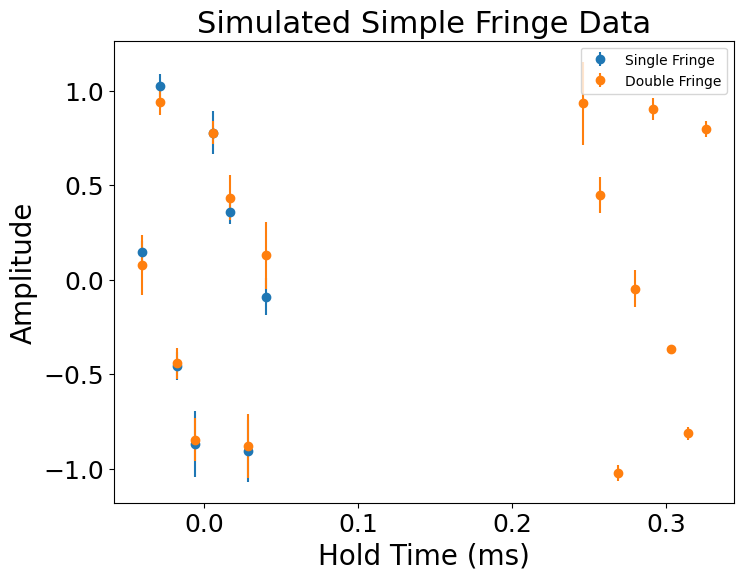

In [703]:
plt.errorbar(time1*1e3, data1, yerr=data1_std, label='Single Fringe', fmt='o')
plt.errorbar(time2*1e3, data2, yerr=data2_std, label='Double Fringe', fmt='o')
plt.xlabel('Hold Time (ms)')
plt.ylabel('Amplitude')
# plt.xlim(-0.05, 0.05)
plt.title("Simulated Simple Fringe Data")
plt.legend()
plt.show()

In [704]:
def square_sin_error_weighted(time, data, data_sig, freqs, phis, want_2d):
    freq_errors=[]
    for f in freqs:
        phi_errors=[]
        for phi in phis: 
            phi_errors.append(0.5*np.sum(1/(data_sig**2) * (data - np.sin(2*np.pi*f*time + phi))**2))
        if want_2d:
            freq_errors.append(phi_errors)
        else:
            freq_errors.append(np.min(phi_errors))
    return np.array(freq_errors)

In [705]:
phi_range = np.linspace(-np.pi, np.pi, 100)
freq_range = np.linspace(0, f_samp/2, 1000)

print(phi_range.size)
print(time1.size)
print(freq_range.size)

errors_gate_2d = square_sin_error_weighted(time1, data1, data1_std, freq_range, phi_range, want_2d=True)
gate_mesh = np.meshgrid(phi_range, freq_range)
errors_gate_1d = square_sin_error_weighted(time1, data1, data1_std, freq_range, phi_range, want_2d=False)

100
8
1000


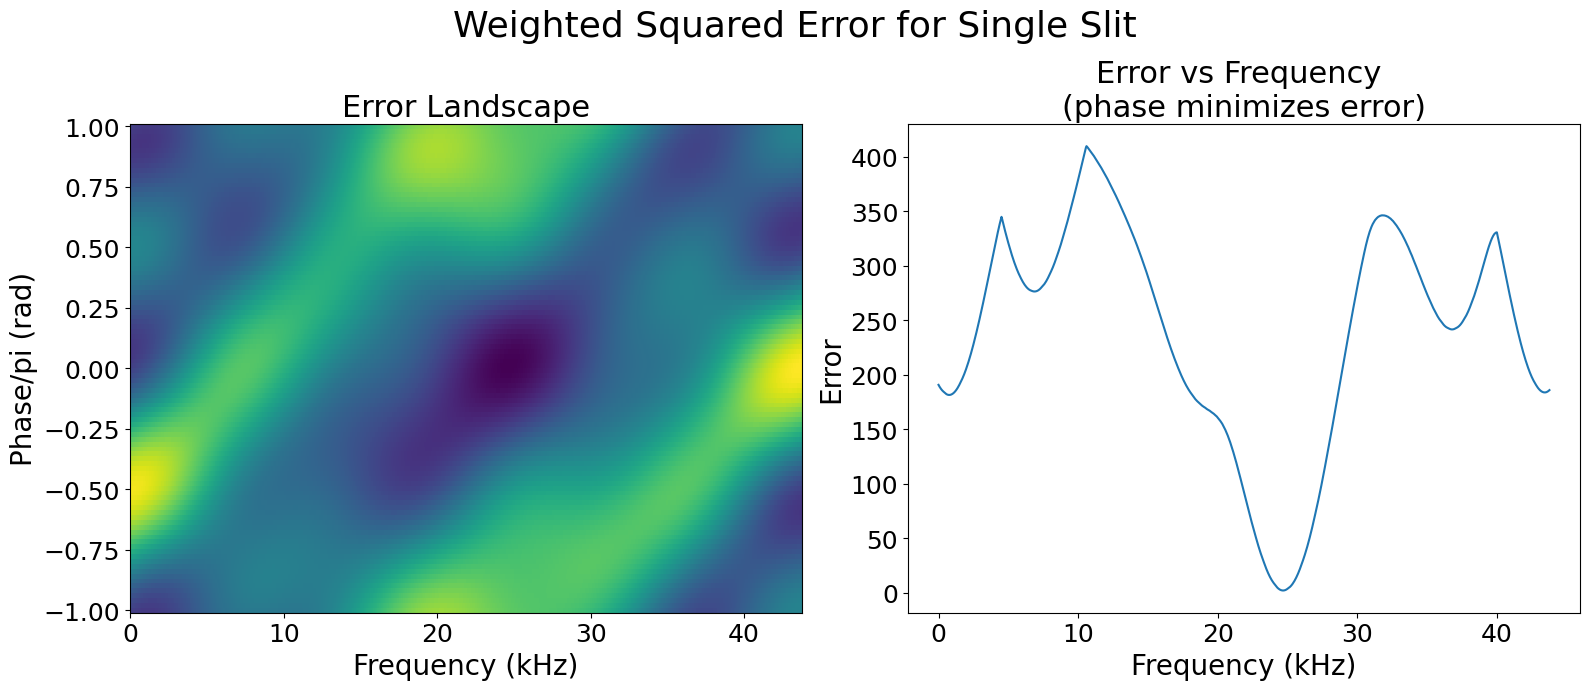

In [706]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].pcolormesh(gate_mesh[1]*1e-3, gate_mesh[0]/(np.pi), errors_gate_2d, shading='auto')
ax[0].set_title('Error Landscape')
ax[0].set_ylabel('Phase/pi (rad)')
ax[0].set_xlabel('Frequency (kHz)')

ax[1].plot(freq_range*1e-3, errors_gate_1d)
ax[1].set_title('Error vs Frequency \n(phase minimizes error)')
ax[1].set_ylabel('Error')
ax[1].set_xlabel('Frequency (kHz)')


plt.suptitle('Weighted Squared Error for Single Slit', fontsize=26)
plt.tight_layout()

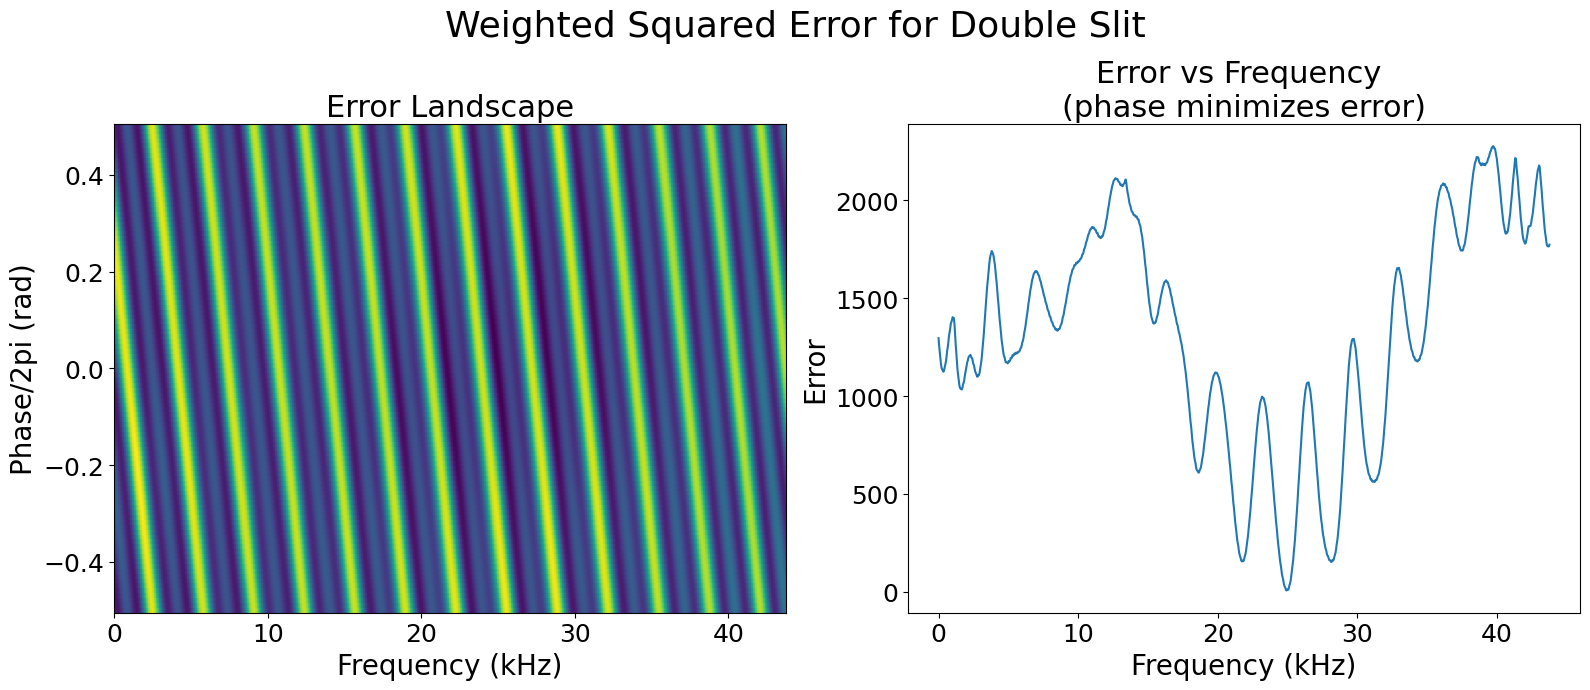

In [707]:

errors_2gate_2d = square_sin_error_weighted(time2, data2, data2_std, freq_range, phi_range, want_2d=True)
gate_mesh2 = np.meshgrid(phi_range, freq_range)
errors_2gate_1d = square_sin_error_weighted(time2, data2, data2_std, freq_range, phi_range, want_2d=False)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].pcolormesh(gate_mesh2[1]*1e-3, gate_mesh2[0]/(2*np.pi), errors_2gate_2d, shading='auto')
ax[0].set_title('Error Landscape')
ax[0].set_ylabel('Phase/2pi (rad)')
ax[0].set_xlabel('Frequency (kHz)')

ax[1].plot(freq_range*1e-3, errors_2gate_1d)
ax[1].set_title('Error vs Frequency \n(phase minimizes error)')
ax[1].set_ylabel('Error')
ax[1].set_xlabel('Frequency (kHz)')


plt.suptitle('Weighted Squared Error for Double Slit', fontsize=26)
plt.tight_layout()

### Stats xplor

1) Figure out how to add wieghts to sqr ✅ 

2) ~~Figure out how to compute cov matrix from err landscape~~

3) Implement scipy fitting on single data set  ✅ 

4) Figure out how to get error of ellipse from pcov matrix ✅ 

5) ~~Compare pcov and first principles ellipses of error~~

6) ~~Compare full results from both methods to see whats really going on under the curve_fit hood~~






### Error Ellipse Proceedure

1) get cov matrix and diagonalize to get the eigenvectors and eigenvalues ✅ 

2) Generate an axis aligned ellipse using the eigenvalues as the stand alone variances.  ✅ 

3) rotate the ellipse using the already normalized eigenvectors matrix!  ✅ 


In [708]:
def gen_ellipse(pcov_subspace, popt_subvector, s=5.991):
    
    # Get ellipse center
    x_0 = popt_subvector[0]  # frequency
    y_0 = popt_subvector[1]  # phase
    
    #get eigvals, eigvecs of cov matrix. Eigvals are the variances in pre-rotated frame
    evals, evecs = np.linalg.eigh(pcov_subspace)

    # Generate ellipse parametrically
    t = np.linspace(0, 2*np.pi, 100)
    a = np.sqrt(s * evals[0]) 
    b = np.sqrt(s * evals[1])
    x_std = a * np.cos(t)
    y_std = b * np.sin(t)

    # stack to prep for rotation by matrix mult
    points_std = np.vstack([x_std, y_std])
    
    # Eigvec matrix happens to be rotation matrix we need
    rotated_points = evecs @ points_std
    
    # Translate to be centered on the fit convergence value
    rotated_points[0] = rotated_points[0] + x_0
    rotated_points[1] = rotated_points[1] + y_0

    return rotated_points



In [709]:
def sin_func(t, A_0, A, f, phi):
    return A_0 + A * np.sin(2 * np.pi * f * t + phi)

popt, pcov = curve_fit(sin_func, time1, data1, p0=[0, 1, f_0, 0], sigma=data1_std)

print(popt)
print('')
print('Covariance Matrix:')

print(pcov)

print('')
print('Just freq, phase')
print(popt[2:])
print('')
print('Just bottom 2x2 jordan block:')
print(pcov[2:, 2:])

print('')
print('Eigen results:')
evals, evecs = np.linalg.eigh(pcov[2:, 2:])
print('Eigenvalues:')
print(evals)
print('Eigenvectors:')
print(evecs)


print(evals.argmax())

sub_vec = popt[2:]
sub_mat = pcov[2:, 2:]

[4.72094244e-03 1.01705719e+00 2.47114780e+04 4.53766188e-02]

Covariance Matrix:
[[ 1.03527346e-03 -6.71575489e-04  1.37586786e+00  4.76533075e-05]
 [-6.71575489e-04  2.86284403e-03  2.17713079e-01  1.24685865e-04]
 [ 1.37586786e+00  2.17713079e-01  3.81610681e+04  2.27947949e+00]
 [ 4.76533075e-05  1.24685865e-04  2.27947949e+00  1.35783776e-03]]

Just freq, phase
[2.47114780e+04 4.53766188e-02]

Just bottom 2x2 jordan block:
[[3.81610681e+04 2.27947949e+00]
 [2.27947949e+00 1.35783776e-03]]

Eigen results:
Eigenvalues:
[1.22167734e-03 3.81610682e+04]
Eigenvectors:
[[ 5.97331172e-05 -9.99999998e-01]
 [-9.99999998e-01 -5.97331172e-05]]
1


In [716]:
def fit_and_plot(time, data, data_unc, init_guess, color, no):
    popt, pcov = curve_fit(sin_func, time, data, p0=init_guess, sigma=data_unc)
    print(f'Fit {no} Results:')
    print(f'  Offset: {popt[3]:.3f} ± {np.sqrt(pcov[0,0]):.3f}')
    print(f'  Amplitude: {popt[0]:.3f} ± {np.sqrt(pcov[1, 1]):.3f}')
    print(f'  Frequency: {popt[1]:.3f} ± {np.sqrt(pcov[2, 2]):.3f}')
    print(f'  Phase: {popt[2]:.3f} ± {np.sqrt(pcov[3, 3]):.3f}')
    sub_vec = popt[2:]
    sub_mat = pcov[2:, 2:]
    rot_ellipse = gen_ellipse(sub_mat, sub_vec)
    plt.plot(rot_ellipse[0]*1e-3, rot_ellipse[1]/np.pi, label=f'Fit {no} Ellipse', color=color)
    plt.plot(popt[2]*1e-3, popt[3]/np.pi, '*', label=f'Fit {no} Convergence', color=color, markersize=10)
    plt.plot(np.array([init_guess[2],popt[2]])*1e-3, np.array([init_guess[3],popt[3]])/np.pi, label=f'Fit {no} Path', color=color, linestyle='--')
    return popt, pcov

In [717]:
def find_global_min(errors_gate_2d, freq_range, phi_range):
    global_min_idx = np.unravel_index(np.argmin(errors_gate_2d), errors_gate_2d.shape)
    return freq_range[global_min_idx[0]], phi_range[global_min_idx[1]]  
print(find_global_min(errors_gate_2d, freq_range*1e-3, phi_range/np.pi))

(24.655905905905907, 0.010101010101010206)


Fit 1 Results:
  Offset: -1.548 ± 9784193.173
  Amplitude: -292.366 ± 9784192.957
  Frequency: -292.708 ± 2168295.385
  Phase: 129.181 ± 376.790
Fit 2 Results:
  Offset: 0.045 ± 0.032
  Amplitude: 0.005 ± 0.054
  Frequency: 1.017 ± 195.348
  Phase: 24711.479 ± 0.037
Fit 3 Results:
  Offset: 0.045 ± 0.032
  Amplitude: 0.005 ± 0.054
  Frequency: 1.017 ± 195.349
  Phase: 24711.478 ± 0.037
24711.477883117648 0.045376654413799594


/home/foresttschirhart/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


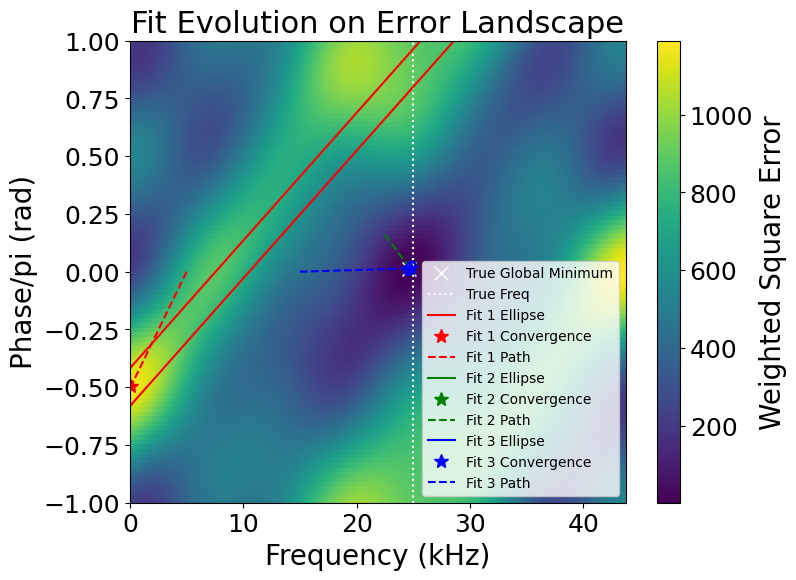

In [ ]:
# plt.pcolormesh(gate_mesh[1]*1e-3, gate_mesh[0]/(np.pi), errors_gate_2d, shading='auto', norm=colors.LogNorm())
plt.pcolormesh(gate_mesh[1]*1e-3, gate_mesh[0]/(np.pi), errors_gate_2d, shading='auto')
plt.colorbar(label='Weighted Square Error')

min_freq, min_phi = find_global_min(errors_gate_2d, freq_range*1e-3, phi_range/np.pi)
plt.plot(min_freq, min_phi, 'x', label='True Global Minimum', color='w', markersize=10)
plt.axvline(f_0*1e-3, 0, label='True Freq', color='w', linestyle=':')

fit_and_plot(time1, data1, data1_std, [0, 1, f_0*0.2, 0], 'r', 1)
fit_and_plot(time1, data1, data1_std, [0, 1, f_0*0.9, 0.5], 'g', 2)
popt1, pcov1 = fit_and_plot(time1, data1, data1_std, [0, 1, f_0*0.6, 0], 'b', 3)


plt.xlim(0,f_samp/2*1e-3)
plt.ylim(-1,1)
plt.legend()
plt.title('Fit Evolution on Error Landscape')
plt.ylabel('Phase/pi (rad)')
plt.xlabel('Frequency (kHz)')


In [ ]:
fit1_f, fit1_phi = popt1[2], popt1[3]
fit1_f_err, fit1_phi_err = np.sqrt(pcov1[2,2]), np.sqrt(pcov1[3,3])
print(f'Fit F1: {fit1_f*1e-3:.3f} +/- {fit1_f_err*1e-3:.3f} kHz')
print(f'Fit Phi1: {fit1_phi/np.pi:.3f} +/- {fit1_phi_err/np.pi:.3f} pi')


Fit F1: 24.711 +/- 0.195 kHz
Fit Phi1: 0.014 +/- 0.012 pi


Fit 2 Results:
  Offset: 0.045 ± 0.032
  Amplitude: 0.005 ± 0.054
  Frequency: 1.017 ± 195.348
  Phase: 24711.479 ± 0.037
Fit 3 Results:
  Offset: 0.045 ± 0.032
  Amplitude: 0.005 ± 0.054
  Frequency: 1.017 ± 195.349
  Phase: 24711.478 ± 0.037


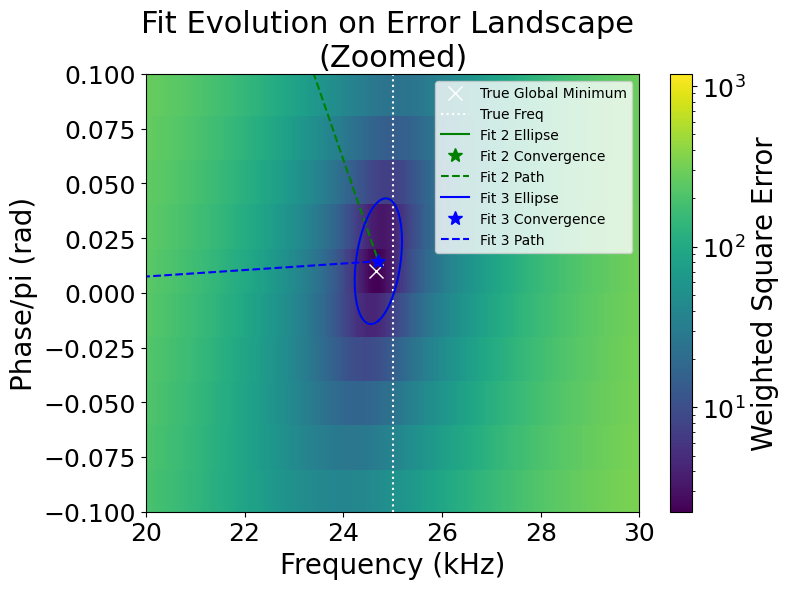

In [713]:
plt.pcolormesh(gate_mesh[1]*1e-3, gate_mesh[0]/(np.pi), errors_gate_2d, shading='auto', norm=colors.LogNorm())
# plt.pcolormesh(gate_mesh[1]*1e-3, gate_mesh[0]/(np.pi), errors_gate_2d, shading='auto')
plt.colorbar(label='Weighted Square Error')

min_freq, min_phi = find_global_min(errors_gate_2d, freq_range*1e-3, phi_range/np.pi)
plt.plot(min_freq, min_phi, 'x', label='True Global Minimum', color='w', markersize=10)
plt.axvline(f_0*1e-3, 0, label='True Freq', color='w', linestyle=':')

fit_and_plot(time1, data1, data1_std, [0, 1, f_0*0.9, 0.5], 'g', 2)
fit_and_plot(time1, data1, data1_std, [0, 1, f_0*0.6, 0], 'b', 3)

plt.xlim(20,30)
plt.ylim(-0.1,.1)
plt.legend()
plt.title('Fit Evolution on Error Landscape \n(Zoomed)')
plt.ylabel('Phase/pi (rad)')
plt.xlabel('Frequency (kHz)')
plt.tight_layout()


Fit 1 Results:
  Offset: -1.181 ± 0.276
  Amplitude: -0.027 ± 0.285
  Frequency: -0.529 ± 860.407
  Phase: 5216.607 ± 1.442
Fit 2 Results:
  Offset: -0.179 ± 0.062
  Amplitude: 0.100 ± 0.101
  Frequency: 1.038 ± 107.911
  Phase: 21802.114 ± 0.197
Fit 3 Results:
  Offset: -0.750 ± 0.197
  Amplitude: -0.053 ± 0.332
  Frequency: 0.449 ± 680.685
  Phase: 15641.185 ± 1.180
Fit 4 Results:
  Offset: 6.297 ± 0.012
  Amplitude: 0.007 ± 0.018
  Frequency: 1.003 ± 23.452
  Phase: 24959.774 ± 0.043
Fit Single Slit Results:
  Offset: 0.045 ± 0.032
  Amplitude: 0.005 ± 0.054
  Frequency: 1.017 ± 195.349
  Phase: 24711.478 ± 0.037


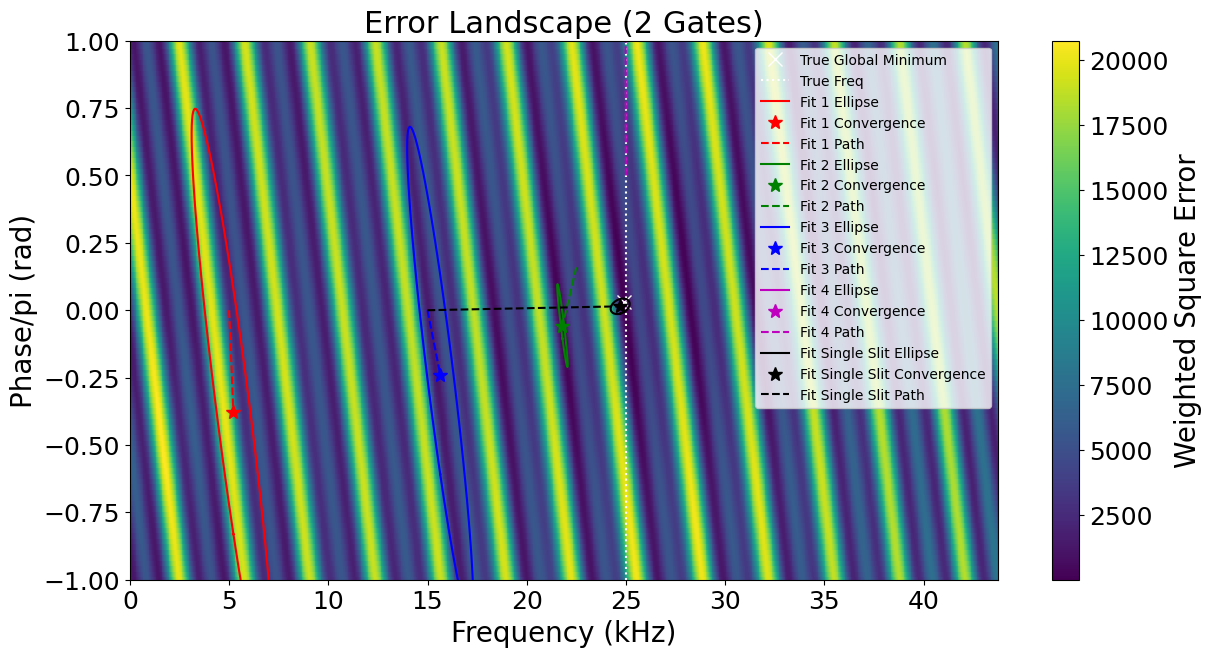

In [714]:
plt.figure(figsize=(14, 7))
plt.pcolormesh(gate_mesh2[1]*1e-3, gate_mesh2[0]/(np.pi), errors_2gate_2d, shading='auto')

min_freq2, min_phi2 = find_global_min(errors_2gate_2d, freq_range*1e-3, phi_range/np.pi)
plt.plot(min_freq2, min_phi2, 'x', label='True Global Minimum', color='w', markersize=10)
plt.axvline(f_0*1e-3, 0, label='True Freq', color='w', linestyle=':')

fit_and_plot(time2, data2, data2_std, [0, 1, f_0*0.2, 0], 'r', 1)
fit_and_plot(time2, data2, data2_std, [0, 1, f_0*0.9, 0.5], 'g', 2)
fit_and_plot(time2, data2, data2_std, [0, 1, f_0*0.6, 0], 'b', 3)
fit_and_plot(time2, data2, data2_std, [0, 1, f_0, 0.5*np.pi], 'm', 4)


fit_and_plot(time1, data1, data1_std, [0, 1, f_0*0.6, 0], 'black', 'Single Slit')

plt.colorbar(label='Weighted Square Error')
plt.title('Error Landscape (2 Gates)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Phase/pi (rad)')
plt.xlim(0, f_samp/2*1e-3)
plt.ylim(-1,1)
plt.legend()


Fit 1 Results:
  Offset: -3.128 ± 0.012
  Amplitude: 0.007 ± 0.018
  Frequency: -1.003 ± 23.452
  Phase: 24959.774 ± 0.043
Fit 4 Results:
  Offset: 6.297 ± 0.012
  Amplitude: 0.007 ± 0.018
  Frequency: 1.003 ± 23.452
  Phase: 24959.774 ± 0.043
Fit Single Slit Results:
  Offset: 0.045 ± 0.032
  Amplitude: 0.005 ± 0.054
  Frequency: 1.017 ± 195.349
  Phase: 24711.478 ± 0.037


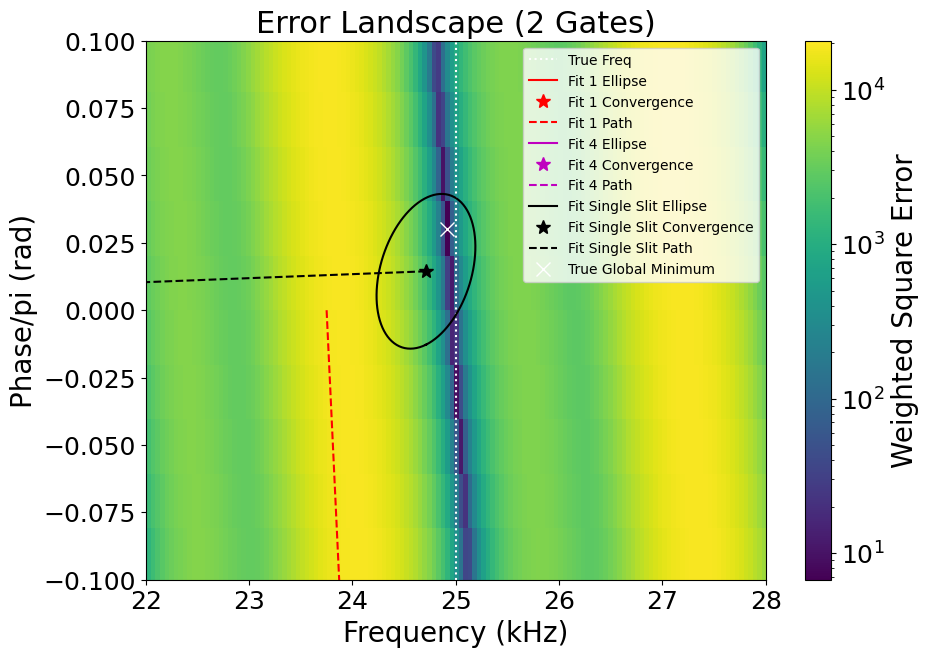

In [715]:
plt.figure(figsize=(10, 7))

plt.pcolormesh(gate_mesh2[1]*1e-3, gate_mesh2[0]/(np.pi), errors_2gate_2d, shading='auto', norm=colors.LogNorm())

plt.axvline(f_0*1e-3, 0, label='True Freq', color='w', linestyle=':')

fit_and_plot(time2, data2, data2_std, [0, 1, f_0*0.95, 0], 'r', 1)
fit_and_plot(time2, data2, data2_std, [0, 1, f_0, 0.5*np.pi], 'm', 4)

fit_and_plot(time1, data1, data1_std, [0, 1, f_0*0.6, 0], 'black', 'Single Slit')


min_freq2, min_phi2 = find_global_min(errors_2gate_2d, freq_range*1e-3, phi_range/np.pi)
plt.plot(min_freq2, min_phi2, 'x', label='True Global Minimum', color='w', markersize=10)

plt.colorbar(label='Weighted Square Error')
plt.title('Error Landscape (2 Gates)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Phase/pi (rad)')
plt.xlim(22,28)
plt.ylim(-0.1,.1)
plt.legend()


### Bootstrapping proceedure

1) Generate a single measurement and fit it using curve fit  ✅ 

2) Reserach how error propagates  ✅ 

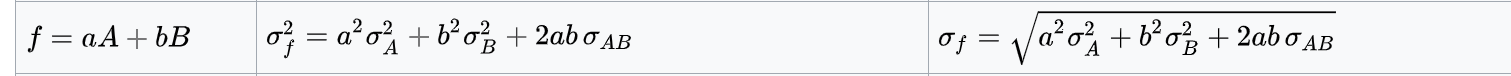

so for this phase eqn: __2pi*f*t +phi__
We get: __var_phase = ((2pi*t)^2 * var_f) + (var_phi) + (2cov_f_phi * 2pi*t)__

3) Implement how error propagates and find where unc is less than 2pi

4) Generate a double slit measurement with the desired spacing from the prev step. Look only at the second window and do a fit (only to this part so that we dont get phase-freq correlated striping)

5) The Phase fit should be allowed to vary as much as possible but at the end you should mod 2pi it

6) Once the phase fit is grabbed (its relative to the center of the measurement window) add this phase to each multiple of 2pi on the error prop graph. Whichever resulting point lies in the cone of error is the new point. 

7) Re-fit the data using the averaged frequency fits from both fits as the init seed. Then once you get the line look at the error in the slope and intercept. 



In [634]:
f_1 = 25e3
tau_1 = 1 / f_1
f_samp1 = f_1 * 3.5
width1 = 2 * tau_1

class Fringe:
    def __init__(self, A_0, A, f_0, phi):
        self.f_0 = f_0
        self.A_0 = A_0
        self.A = A
        self.phi = phi

    def eval_pure(self, t):
        return self.A_0 + self.A * np.sin(2 * np.pi * self.f_0 * t + self.phi)

    def add_noise(self, data, noise_level):
        noise = np.random.normal(0, noise_level, size=data.shape)
        return data + noise
    
    def eval_noisy(self, t):
        data_pure = self.eval_pure(t)
        data1 = self.add_noise(np.array(data_pure), noise_level=0.3)
        data2 = self.add_noise(np.array(data_pure), noise_level=0.2)
        data3 = self.add_noise(np.array(data_pure), noise_level=0.1)
        data_avg = np.mean([data1, data2, data3], axis=0)
        data_std = np.std([data1, data2, data3], axis=0)

        return data_avg, data_std

def gen_sample(fringe, t_hold_center, f_samp, no_samp):
    if no_samp % 2 == 0:
        raise ValueError("no_samp must be odd")
    dt = 1 / f_samp
    half_span = (no_samp - 1) // 2 * dt
    t_range = np.linspace(t_hold_center - half_span, 
                          t_hold_center + half_span, 
                          no_samp)
    avg, std = fringe.eval_noisy(t_range)
    # print(t_range)
    return t_range, avg, std


Text(0.5, 1.0, 'Ex. Object Oriented Fringe \n[T hold center value: 0.8 ms, 11 desired points]')

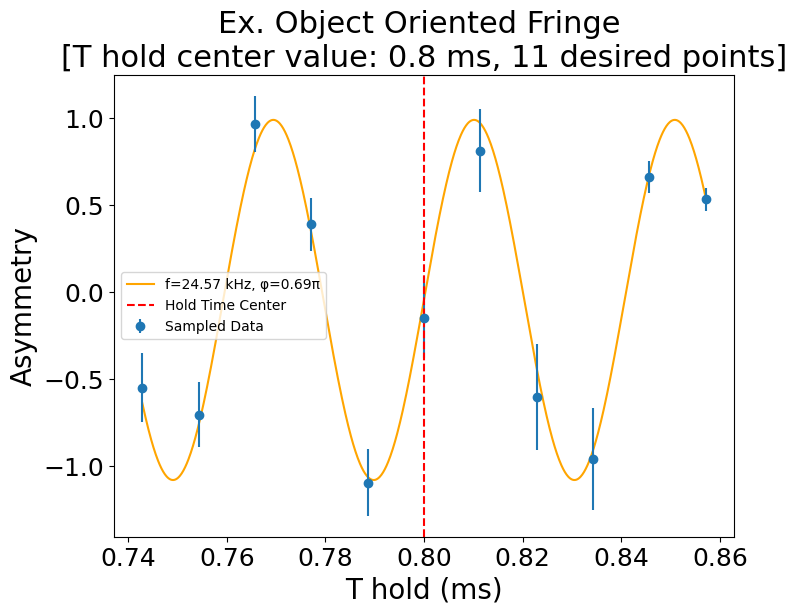

In [635]:
want_no_samp = 11
center_t1_hold = tau_1*20
little_g_fringe = Fringe(A_0=0, A=1, f_0=f_1, phi=0)
t01s, avg01s, std01s = gen_sample(little_g_fringe, center_t1_hold, f_samp1, want_no_samp)
popt1, pcov1 = curve_fit(sin_func, t01s, avg01s, p0=[0, 1, f_1, 0], sigma=std01s)
plot_t1s = np.linspace(t01s[0], t01s[-1], 1000)
fringe_fit = sin_func(plot_t1s, *popt1)
plt.plot(plot_t1s*1e3, fringe_fit, label=f'f={popt1[2]*1e-3:.2f} kHz, φ={popt1[3]/np.pi:.2f}π', color='orange')
plt.errorbar(t01s*1e3, avg01s, yerr=std01s, fmt='o', label='Sampled Data')
plt.axvline(center_t1_hold*1e3, color='r', linestyle='--', label='Hold Time Center')
plt.xlabel('T hold (ms)')
plt.ylabel('Asymmetry')
plt.legend()
plt.title(f'Ex. Object Oriented Fringe \n[T hold center value: {center_t1_hold*1e3:.1f} ms, {want_no_samp} desired points]')

In [661]:
true_f = little_g_fringe.f_0 
true_phi_0 = little_g_fringe.phi

In [636]:
def phase_prop(t_range, f, phi):
    return 2 * np.pi * f * t_range + phi

def phase_error_prop(t_range, var_f, var_phi, cov_f_phi):
    var_phase = ((2 * np.pi * t_range)**2 * var_f) + (var_phi) + (2 * cov_f_phi * 2 * np.pi * t_range)
    return np.sqrt(var_phase)


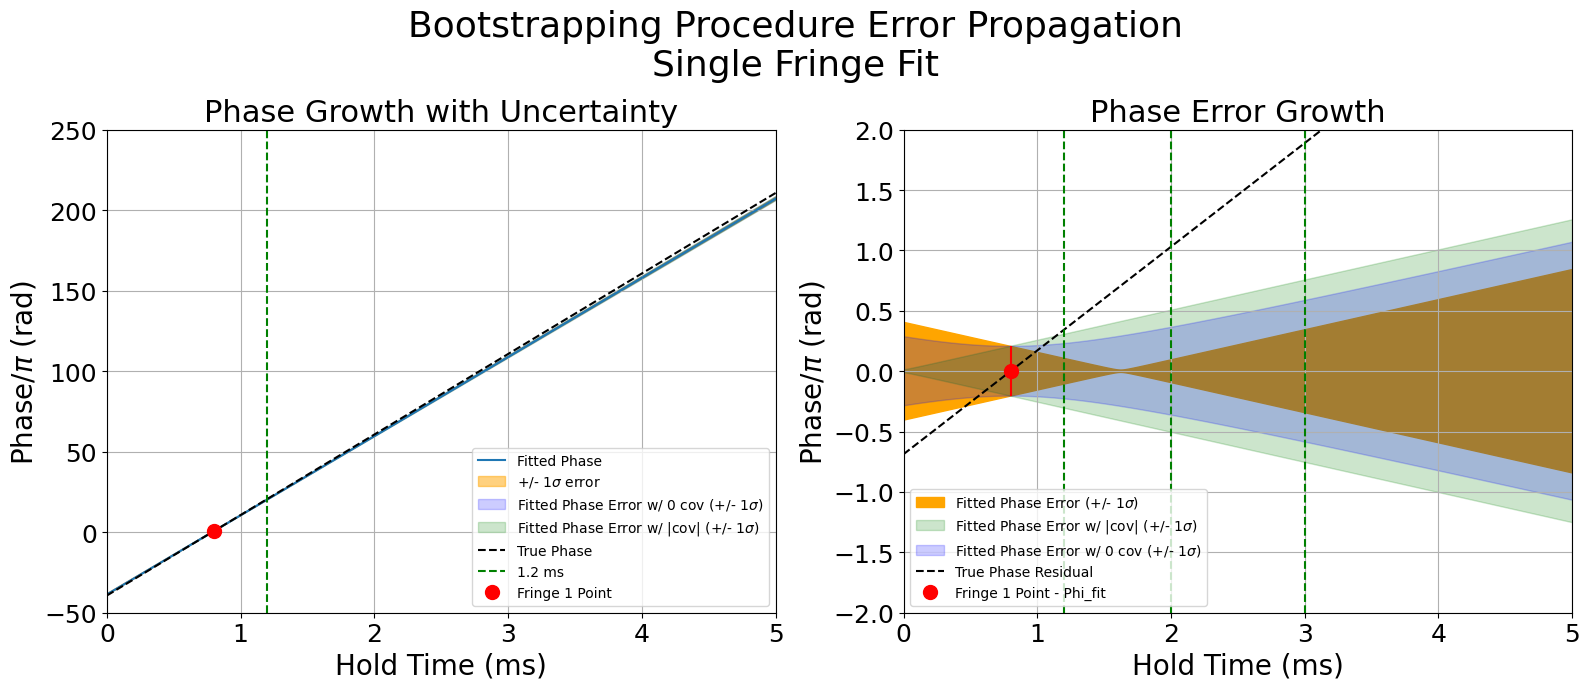

In [665]:

freq_fit = popt1[2]
phi_fit = popt1[3]
freq_var = pcov1[2, 2]
phi_var = pcov1[3, 3]
freq_phi_cov = pcov1[2, 3]

# print(pcov1)

t_range_prop = np.linspace(0, 1000*tau_1, 10000)
true_phase = phase_prop(t_range_prop-center_t1_hold, true_f, phi_fit)


phase_fit = phase_prop(t_range_prop-center_t1_hold, freq_fit, phi_fit)
phase_error_true = phase_error_prop(t_range_prop-center_t1_hold, freq_var, phi_var, freq_phi_cov)
phase_error_abscov = phase_error_prop(t_range_prop-center_t1_hold, freq_var, phi_var, np.abs(freq_phi_cov))
phase_error_0cov = phase_error_prop(t_range_prop-center_t1_hold, freq_var, phi_var, 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot(t_range_prop*1e3, phase_fit/(np.pi), label='Fitted Phase')
ax[0].fill_between(t_range_prop*1e3, (phase_fit - phase_error_true)/(np.pi), (phase_fit + phase_error_true)/(np.pi), color='orange', alpha=0.5, label=r'+/- 1$\sigma$ error')
ax[0].fill_between(t_range_prop*1e3, (phase_fit + phase_error_0cov)/(np.pi), (phase_fit-phase_error_0cov)/(np.pi), label=r'Fitted Phase Error w/ 0 cov (+/- 1$\sigma$)', color='blue', alpha=0.2)
ax[0].fill_between(t_range_prop*1e3, (phase_fit + phase_error_abscov)/(np.pi), (phase_fit-phase_error_abscov)/(np.pi), label=r'Fitted Phase Error w/ |cov| (+/- 1$\sigma$)', color='green', alpha=0.2)
ax[0].plot(t_range_prop*1e3, true_phase/(np.pi), label='True Phase', color='black', linestyle='--')

ax[0].set_xlabel('Hold Time (ms)')
ax[0].set_ylabel(r'Phase/$\pi$ (rad)')

ax[0].set_title('Phase Growth with Uncertainty')
ax[0].axvline(1.2, color='green', linestyle='--', label='1.2 ms')
ax[0].errorbar(center_t1_hold*1e3, (phi_fit)/(np.pi), yerr=np.sqrt(phi_var)/(np.pi), fmt='o', color='red', label='Fringe 1 Point', markersize=10)

ax[0].set_xlim(0, 5)
ax[0].set_ylim(-50,250)
ax[0].grid()
ax[0].legend()

ax[1].fill_between(t_range_prop*1e3, phase_error_true/(np.pi), -1*phase_error_true/(np.pi), label=r'Fitted Phase Error (+/- 1$\sigma$)', color='orange')
ax[1].fill_between(t_range_prop*1e3, phase_error_abscov/(np.pi), -1*phase_error_abscov/(np.pi), label=r'Fitted Phase Error w/ |cov| (+/- 1$\sigma$)', color='green', alpha=0.2)
ax[1].fill_between(t_range_prop*1e3, phase_error_0cov/(np.pi), -1*phase_error_0cov/(np.pi), label=r'Fitted Phase Error w/ 0 cov (+/- 1$\sigma$)', color='blue', alpha=0.2)

ax[1].errorbar(center_t1_hold*1e3, 0, yerr=np.sqrt(phi_var)/(np.pi), fmt='o', color='red', label='Fringe 1 Point - Phi_fit', markersize=10)
ax[1].plot(t_range_prop*1e3, (true_phase-phase_fit)/(np.pi), label='True Phase Residual', color='black', linestyle='--')
ax[1].set_xlabel('Hold Time (ms)')
ax[1].set_ylabel(r'Phase/$\pi$ (rad)')
ax[1].set_xlim(0, 5)
ax[1].set_ylim(-2, 2)
ax[1].set_title('Phase Error Growth')
# ax[1].axhline(1, color='red', linestyle='--', label=r'+$\pi$')
# ax[1].axhline(-1, color='red', linestyle='--', label=r'-$\pi$')
ax[1].axvline(3, color='green', linestyle='--')
ax[1].axvline(2, color='green', linestyle='--')
ax[1].axvline(1.2, color='green', linestyle='--')

ax[1].grid()
ax[1].legend()

fig.suptitle('Bootstrapping Procedure Error Propagation\nSingle Fringe Fit', fontsize=26)
plt.tight_layout()

In [638]:
print(np.sqrt(phi_var)/np.pi)

0.2061078759242574


In [667]:
t2_center = 0.9e-3
t02s, avg02s, std02s = gen_sample(little_g_fringe, t2_center, f_samp1, want_no_samp)

-3.3662772687945517


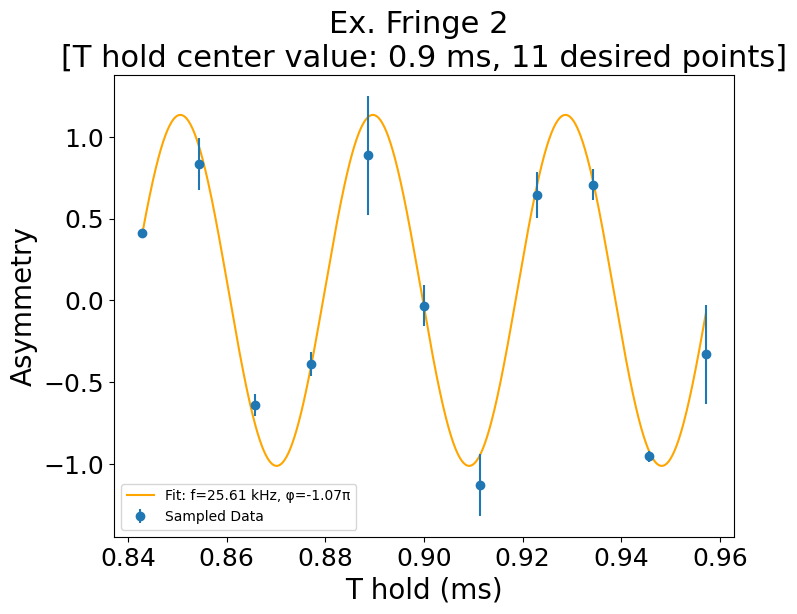

In [668]:

popt2, pcov2 = curve_fit(sin_func, t02s, avg02s, p0=[0, 1, f_1, 0], sigma=std02s)
plot_t2s = np.linspace(t02s[0], t02s[-1], 1000)
fringe_fit = sin_func(plot_t2s, *popt2)
freq_fit2 = popt2[2]
phi_fit2 = popt2[3]
freq_var2 = pcov2[2, 2]
phi_var2 = pcov2[3, 3]
freq_phi_cov2 = pcov2[2, 3]

print(phi_fit2)

plt.plot(plot_t2s*1e3, fringe_fit, color='orange', label=f'Fit: f={freq_fit2*1e-3:.2f} kHz, φ={phi_fit2/np.pi:.2f}π')
plt.errorbar(t02s*1e3, avg02s, yerr=std02s, fmt='o', label='Sampled Data')
plt.xlabel('T hold (ms)')
plt.ylabel('Asymmetry')
plt.title(f'Ex. Fringe 2 \n[T hold center value: {t2_center*1e3:.1f} ms, {want_no_samp} desired points]')
plt.legend()

In [670]:
t3_center = 1e-3 
t03s, avg03s, std03s = gen_sample(little_g_fringe, t3_center, f_samp1, want_no_samp)

1.2991950420252385


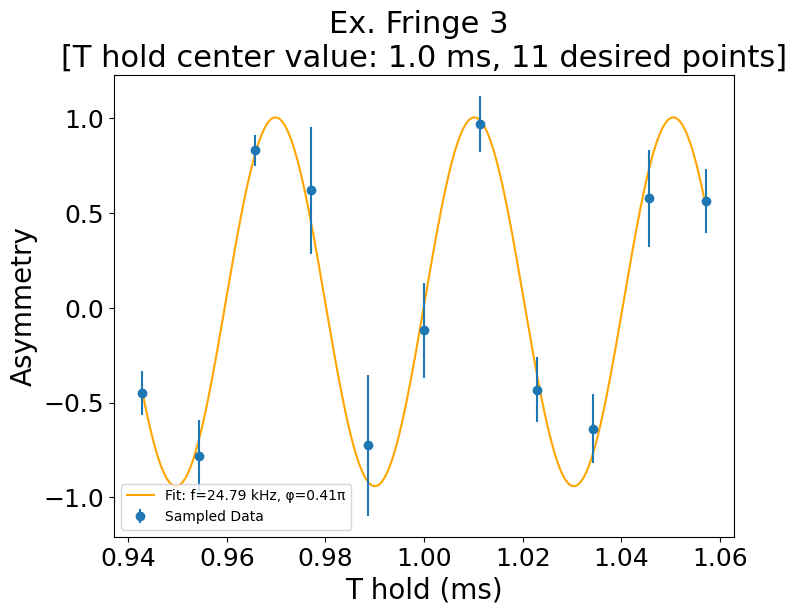

In [671]:
popt3, pcov3 = curve_fit(sin_func, t03s, avg03s, p0=[0, 1, f_1, 0], sigma=std03s)
plot_t3s = np.linspace(t03s[0], t03s[-1], 1000)
fringe_fit = sin_func(plot_t3s, *popt3)
freq_fit3 = popt3[2]
phi_fit3 = popt3[3]
freq_var3 = pcov3[2, 2]
phi_var3 = pcov3[3, 3]
freq_phi_cov3 = pcov3[2, 3]

print(phi_fit3)

plt.plot(plot_t3s*1e3, fringe_fit, color='orange', label=f'Fit: f={freq_fit3*1e-3:.2f} kHz, φ={phi_fit3/np.pi:.2f}π')
plt.errorbar(t03s*1e3, avg03s, yerr=std03s, fmt='o', label='Sampled Data')
plt.xlabel('T hold (ms)')
plt.ylabel('Asymmetry')
plt.title(f'Ex. Fringe 3 \n[T hold center value: {t3_center*1e3:.1f} ms, {want_no_samp} desired points]')
plt.legend()

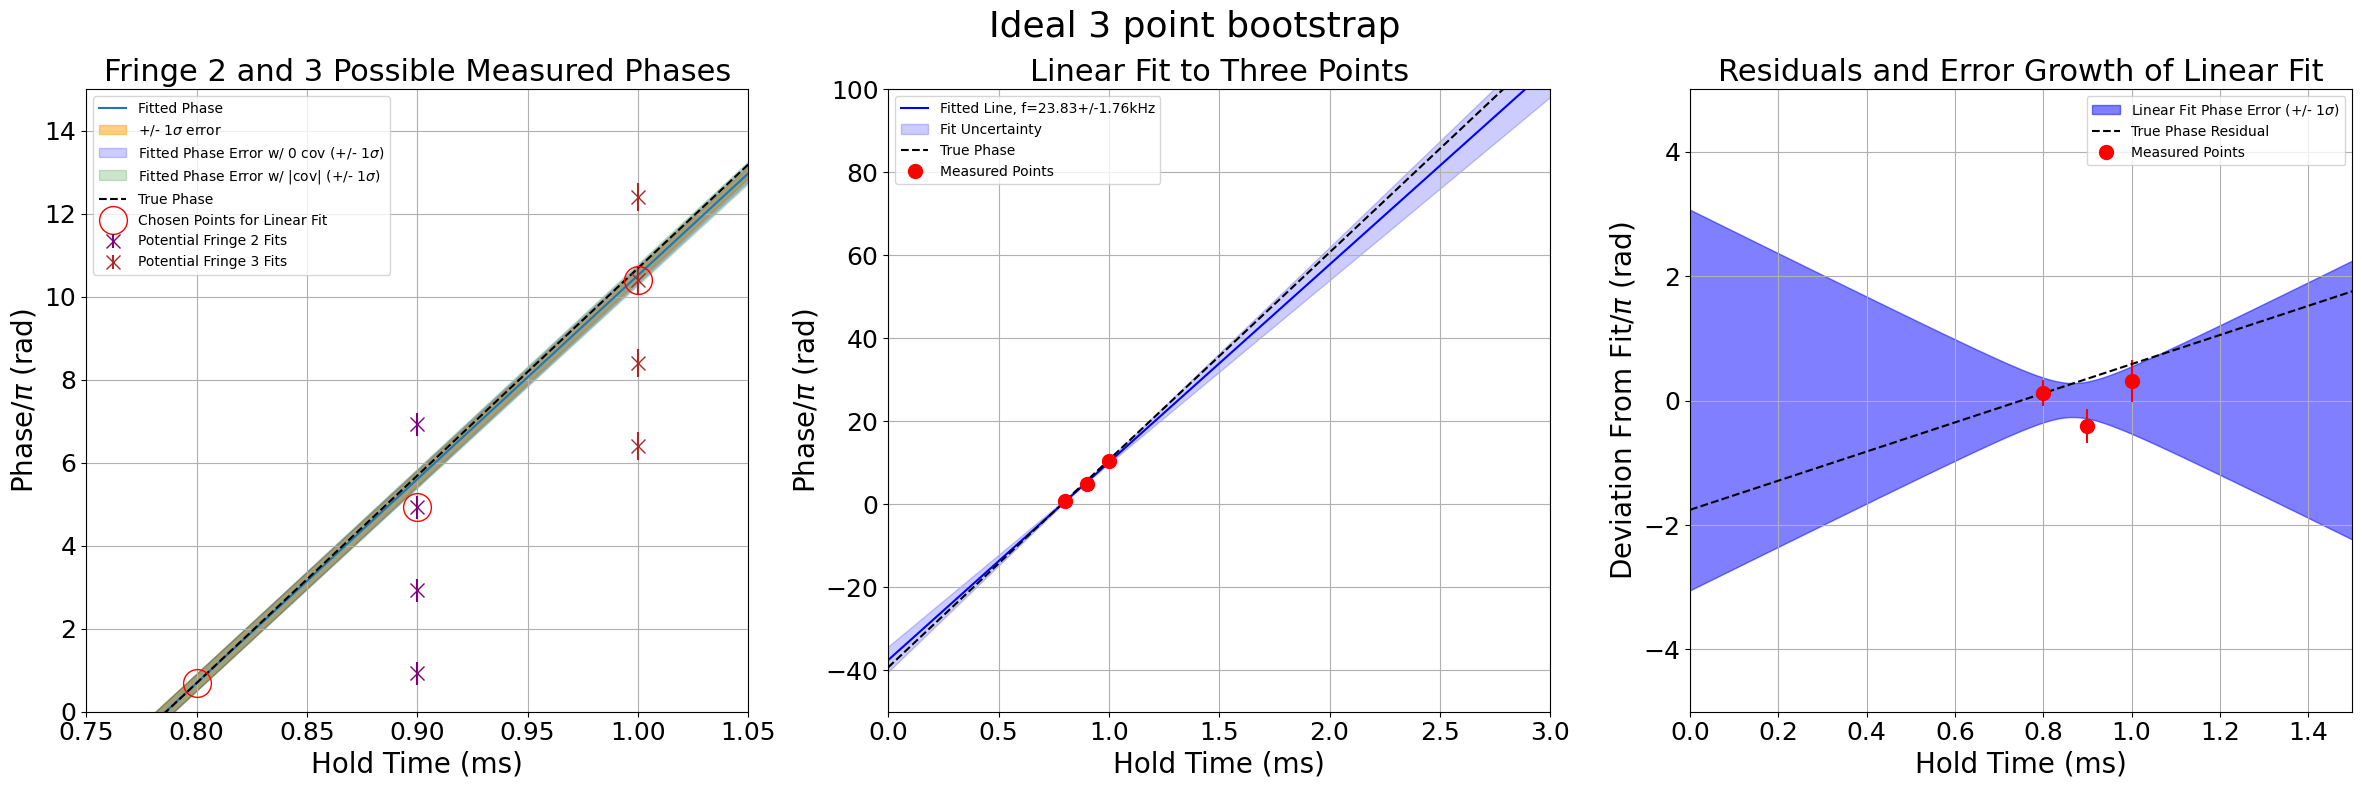

In [686]:
potential_phi2s = np.array([2, 4, 6, 8])*np.pi + phi_fit2
pot_phi2_xs = np.ones_like(potential_phi2s) * t2_center


potential_phi3s = np.array([6, 8, 10, 12])*np.pi + phi_fit3
pot_phi3_xs = np.ones_like(potential_phi3s) * t3_center



fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].plot(t_range_prop*1e3, phase_fit/(np.pi), label='Fitted Phase')
ax[0].fill_between(t_range_prop*1e3, (phase_fit - phase_error_true)/(np.pi), (phase_fit + phase_error_true)/(np.pi), color='orange', alpha=0.5, label=r'+/- 1$\sigma$ error')
ax[0].fill_between(t_range_prop*1e3, (phase_fit + phase_error_0cov)/(np.pi), (phase_fit-phase_error_0cov)/(np.pi), label=r'Fitted Phase Error w/ 0 cov (+/- 1$\sigma$)', color='blue', alpha=0.2)
ax[0].fill_between(t_range_prop*1e3, (phase_fit + phase_error_abscov)/(np.pi), (phase_fit-phase_error_abscov)/(np.pi), label=r'Fitted Phase Error w/ |cov| (+/- 1$\sigma$)', color='green', alpha=0.2)
ax[0].errorbar(pot_phi2_xs*1e3, potential_phi2s/(np.pi), yerr=np.sqrt(phi_var2)/(np.pi), fmt='x', label='Potential Fringe 2 Fits', color='purple', markersize=10)
ax[0].errorbar(pot_phi3_xs*1e3, potential_phi3s/(np.pi), yerr=np.sqrt(phi_var3)/(np.pi), fmt='x', label='Potential Fringe 3 Fits', color='brown', markersize=10)
ax[0].plot(t_range_prop*1e3, true_phase/(np.pi), label='True Phase', color='black', linestyle='--')

ax[0].set_xlabel('Hold Time (ms)')
ax[0].set_ylabel(r'Phase/$\pi$ (rad)')

ax[0].set_title('Fringe 2 and 3 Possible Measured Phases')
# ax[0].axvline(1.2, color='green', linestyle='--', label='1.2 ms')
# ax[0].errorbar(center_t1_hold*1e3, (phi_fit)/(np.pi), yerr=np.sqrt(phi_var)/(np.pi), fmt='o', color='red', label='Fringe 1 Point', markersize=10)



good_phi3 = 10*np.pi + phi_fit3
good_phi3_x = t3_center
good_phi3_std = np.sqrt(phi_var3)

good_phi2 = 6*np.pi + phi_fit2
good_phi2_x = t2_center
good_phi2_std = np.sqrt(phi_var2)

good_phi1 = phi_fit
good_phi1_x = center_t1_hold
good_phi1_std = np.sqrt(phi_var)


phi_lin_fit_x_data = np.array([good_phi1_x, good_phi2_x, good_phi3_x])
phi_lin_fit_y_data = np.array([good_phi1, good_phi2, good_phi3])
phi_lin_fit_y_err = np.array([good_phi1_std, good_phi2_std, good_phi3_std])

ax[0].plot(phi_lin_fit_x_data*1e3, phi_lin_fit_y_data/np.pi, 'o', label='Chosen Points for Linear Fit', color='red', markersize=20, markerfacecolor='none')

ax[0].set_xlim(0.75, 1.05)
ax[0].set_ylim(0,15)
ax[0].grid()
ax[0].legend()



# Fit line to data
popt_lin1, pcov_lin1 = curve_fit(phase_prop, phi_lin_fit_x_data, phi_lin_fit_y_data, sigma=phi_lin_fit_y_err)
f_lin_fit, p_lin_fit = popt_lin1
f_lin_var, p_lin_var = np.diag(pcov_lin1)
fp_lin_cov = pcov_lin1[0, 1]

phase_prop_lin_fit = phase_prop(t_range_prop, f_lin_fit, p_lin_fit)
error_prop_lin_fit = phase_error_prop(t_range_prop, f_lin_var, p_lin_var, fp_lin_cov)
residuals = phi_lin_fit_y_data - phase_prop(phi_lin_fit_x_data, f_lin_fit, p_lin_fit)

ax[1].errorbar(phi_lin_fit_x_data*1e3, phi_lin_fit_y_data/np.pi, yerr=phi_lin_fit_y_err/np.pi, fmt='o', label='Measured Points', color='red', markersize=10)
ax[1].plot(t_range_prop*1e3, phase_prop_lin_fit/np.pi, label=f'Fitted Line, f={f_lin_fit*1e-3:.2f}+/-{np.sqrt(f_lin_var)*1e-3:.2f}kHz', color='blue')
ax[1].fill_between(t_range_prop*1e3, (phase_prop_lin_fit - error_prop_lin_fit)/np.pi, (phase_prop_lin_fit + error_prop_lin_fit)/np.pi, color='blue', alpha=0.2, label='Fit Uncertainty')
ax[1].plot(t_range_prop*1e3, (true_phase)/np.pi, label='True Phase', color='black', linestyle='--')
ax[1].set_xlabel('Hold Time (ms)')
ax[1].set_ylabel(r'Phase/$\pi$ (rad)')  
ax[1].set_title('Linear Fit to Three Points')
ax[1].set_xlim(0, 3)
ax[1].set_ylim(-50, 100)
ax[1].legend()
ax[1].grid()


ax[2].fill_between(t_range_prop*1e3, error_prop_lin_fit/np.pi, -1*error_prop_lin_fit/np.pi, label=r'Linear Fit Phase Error (+/- 1$\sigma$)', color='blue', alpha=0.5)
ax[2].errorbar(phi_lin_fit_x_data*1e3, residuals/np.pi, yerr=phi_lin_fit_y_err/np.pi, fmt='o', label='Measured Points', color='red', markersize=10)
ax[2].plot(t_range_prop*1e3, (true_phase - phase_prop_lin_fit)/np.pi, label='True Phase Residual', color='black', linestyle='--')
ax[2].set_xlabel('Hold Time (ms)')
ax[2].set_ylabel(r'Deviation From Fit/$\pi$ (rad)')
ax[2].set_title('Residuals and Error Growth of Linear Fit')
ax[2].set_xlim(0, 1.5)
ax[2].set_ylim(-5, 5)
ax[2].grid()
ax[2].legend()


fig.suptitle('Ideal 3 point bootstrap', fontsize=26)
plt.tight_layout()



In [687]:
t4_center = 1.1e-3
t04s, avg04s, std04s = gen_sample(little_g_fringe, t4_center, f_samp1, want_no_samp)


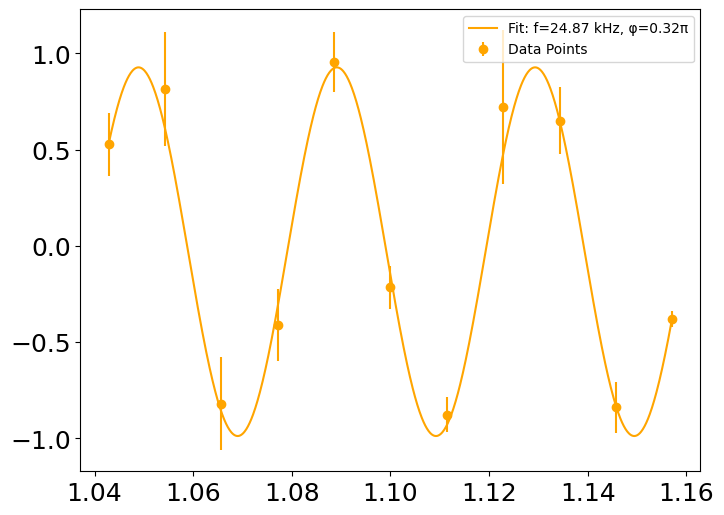

In [689]:
popt4, pcov4 = curve_fit(sin_func, t04s, avg04s, p0=[0, 1, f_1, 0], sigma=std04s)   
plot_t4s = np.linspace(t04s[0], t04s[-1], 1000)
fringe_fit4 = sin_func(plot_t4s, *popt4)
freq_fit4 = popt4[2]
phi_fit4 = popt4[3]
phi_var4 = pcov4[3, 3]
plt.plot(plot_t4s*1e3, fringe_fit4, color='orange', label=f'Fit: f={freq_fit4*1e-3:.2f} kHz, φ={phi_fit4/np.pi:.2f}π')
plt.errorbar(t04s*1e3, avg04s, yerr=std04s, fmt='o', color='orange', label='Data Points')
plt.legend()

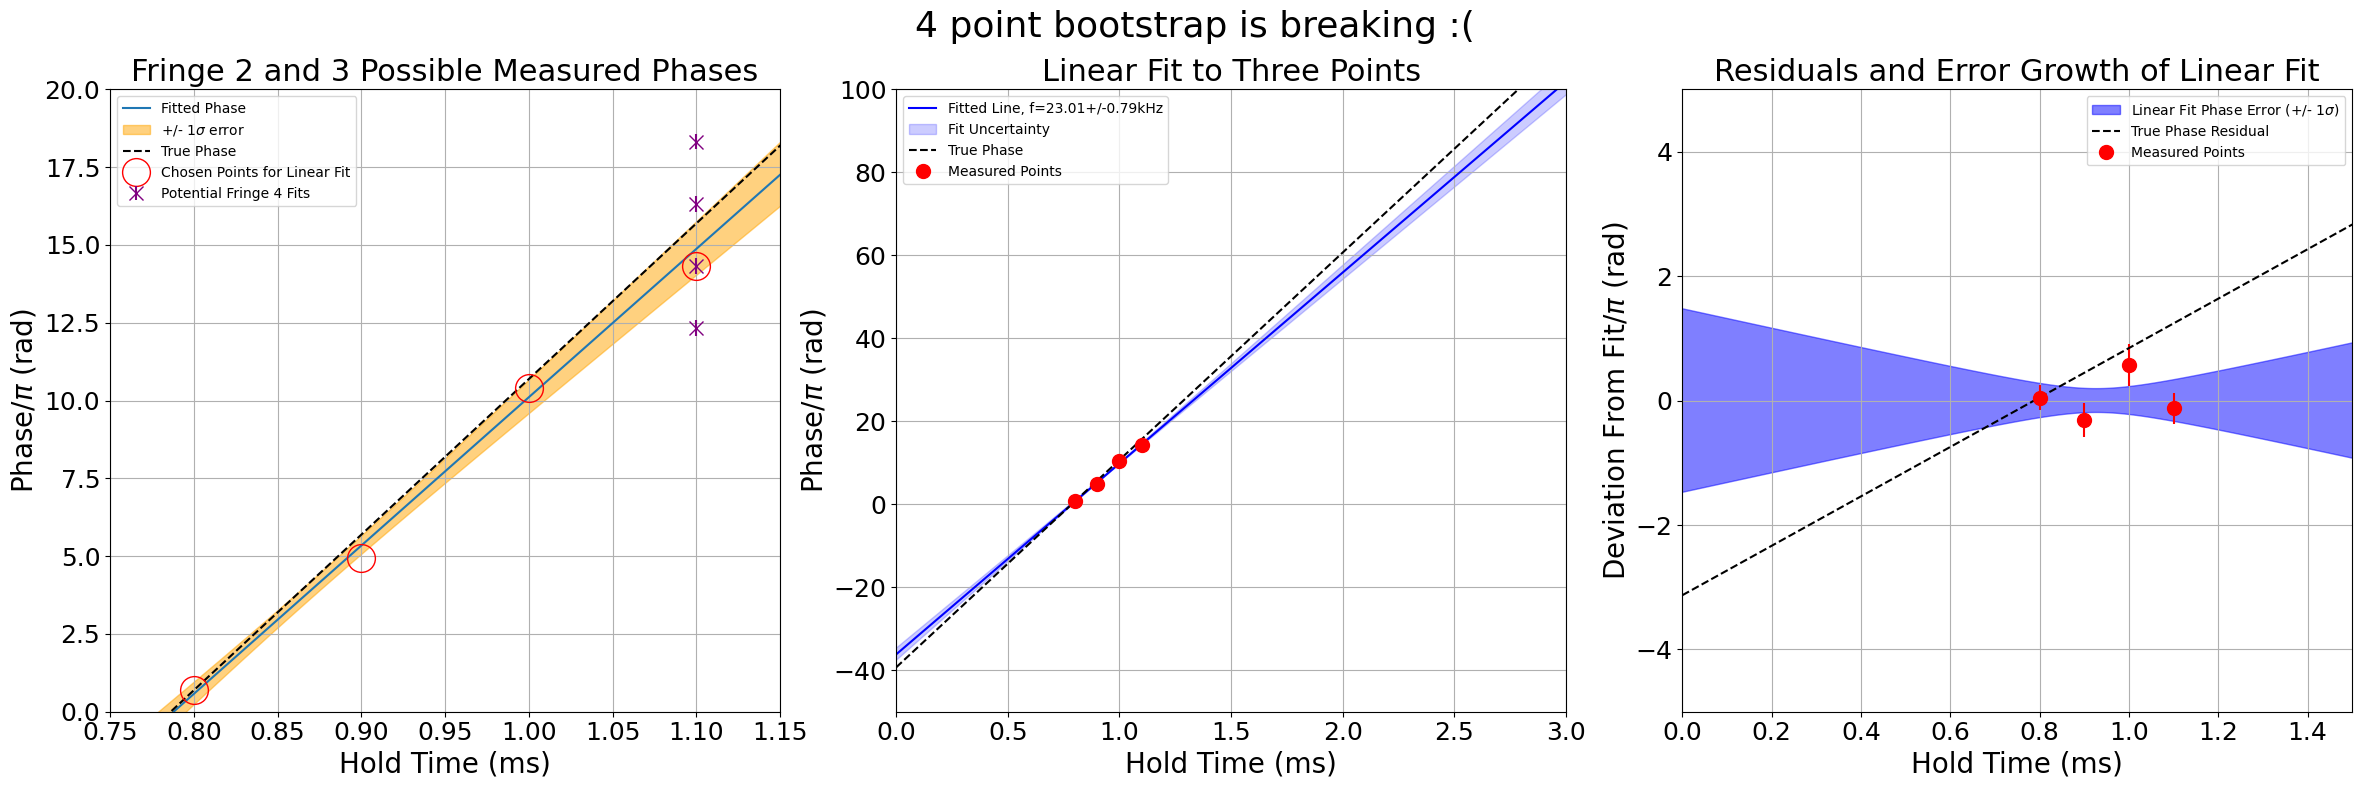

In [699]:
potential_phi4s = np.array([12, 14, 16, 18])*np.pi + phi_fit4
pot_phi4_xs = np.ones_like(potential_phi4s) * t4_center


fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].plot(t_range_prop*1e3, phase_prop_lin_fit/(np.pi), label='Fitted Phase')
ax[0].fill_between(t_range_prop*1e3, (phase_prop_lin_fit - error_prop_lin_fit)/np.pi, (phase_prop_lin_fit + error_prop_lin_fit)/np.pi, color='orange', alpha=0.5, label=r'+/- 1$\sigma$ error')
ax[0].errorbar(pot_phi4_xs*1e3, potential_phi4s/(np.pi), yerr=np.sqrt(phi_var4)/(np.pi), fmt='x', label='Potential Fringe 4 Fits', color='purple', markersize=10)
ax[0].plot(t_range_prop*1e3, true_phase/(np.pi), label='True Phase', color='black', linestyle='--')
ax[0].set_xlabel('Hold Time (ms)')
ax[0].set_ylabel(r'Phase/$\pi$ (rad)')

ax[0].set_title('Fringe 2 and 3 Possible Measured Phases')
# ax[0].axvline(1.2, color='green', linestyle='--', label='1.2 ms')
# ax[0].errorbar(center_t1_hold*1e3, (phi_fit)/(np.pi), yerr=np.sqrt(phi_var)/(np.pi), fmt='o', color='red', label='Fringe 1 Point', markersize=10)



good_phi4 = 14*np.pi + phi_fit4
good_phi4_x = t4_center
good_phi4_std = np.sqrt(phi_var4)

phi_lin_fit_x_data= np.append(phi_lin_fit_x_data, good_phi4_x)
phi_lin_fit_y_data= np.append(phi_lin_fit_y_data, good_phi4)
phi_lin_fit_y_err= np.append(phi_lin_fit_y_err, good_phi4_std)


ax[0].plot(phi_lin_fit_x_data*1e3, phi_lin_fit_y_data/np.pi, 'o', label='Chosen Points for Linear Fit', color='red', markersize=20, markerfacecolor='none')

ax[0].set_xlim(0.75, 1.15)
ax[0].set_ylim(0,20)
ax[0].grid()
ax[0].legend()



# Fit line to data
popt_lin1, pcov_lin1 = curve_fit(phase_prop, phi_lin_fit_x_data, phi_lin_fit_y_data, sigma=phi_lin_fit_y_err)
f_lin_fit, p_lin_fit = popt_lin1
f_lin_var, p_lin_var = np.diag(pcov_lin1)
fp_lin_cov = pcov_lin1[0, 1]

phase_prop_lin_fit = phase_prop(t_range_prop, f_lin_fit, p_lin_fit)
error_prop_lin_fit = phase_error_prop(t_range_prop, f_lin_var, p_lin_var, fp_lin_cov)
residuals = phi_lin_fit_y_data - phase_prop(phi_lin_fit_x_data, f_lin_fit, p_lin_fit)

ax[1].errorbar(phi_lin_fit_x_data*1e3, phi_lin_fit_y_data/np.pi, yerr=phi_lin_fit_y_err/np.pi, fmt='o', label='Measured Points', color='red', markersize=10)
ax[1].plot(t_range_prop*1e3, phase_prop_lin_fit/np.pi, label=f'Fitted Line, f={f_lin_fit*1e-3:.2f}+/-{np.sqrt(f_lin_var)*1e-3:.2f}kHz', color='blue')
ax[1].fill_between(t_range_prop*1e3, (phase_prop_lin_fit - error_prop_lin_fit)/np.pi, (phase_prop_lin_fit + error_prop_lin_fit)/np.pi, color='blue', alpha=0.2, label='Fit Uncertainty')
ax[1].plot(t_range_prop*1e3, (true_phase)/np.pi, label='True Phase', color='black', linestyle='--')
ax[1].set_xlabel('Hold Time (ms)')
ax[1].set_ylabel(r'Phase/$\pi$ (rad)')  
ax[1].set_title('Linear Fit to Three Points')
ax[1].set_xlim(0, 3)
ax[1].set_ylim(-50, 100)
ax[1].legend()
ax[1].grid()


ax[2].fill_between(t_range_prop*1e3, error_prop_lin_fit/np.pi, -1*error_prop_lin_fit/np.pi, label=r'Linear Fit Phase Error (+/- 1$\sigma$)', color='blue', alpha=0.5)
ax[2].errorbar(phi_lin_fit_x_data*1e3, residuals/np.pi, yerr=phi_lin_fit_y_err/np.pi, fmt='o', label='Measured Points', color='red', markersize=10)
ax[2].plot(t_range_prop*1e3, (true_phase - phase_prop_lin_fit)/np.pi, label='True Phase Residual', color='black', linestyle='--')
ax[2].set_xlabel('Hold Time (ms)')
ax[2].set_ylabel(r'Deviation From Fit/$\pi$ (rad)')
ax[2].set_title('Residuals and Error Growth of Linear Fit')
ax[2].set_xlim(0, 1.5)
ax[2].set_ylim(-5, 5)
ax[2].grid()
ax[2].legend()


fig.suptitle('4 point bootstrap is breaking :(', fontsize=26)
plt.tight_layout()
